In [1]:
# dataset.py - Hyperspectral Dataset Handling.
# todo:
# - Implement class distribution analysis and visualization methods.
import os
import torch
import numpy as np
from munch import Munch
from torch.utils.data import Dataset
from abc import ABC, abstractmethod
from typing import Tuple, Dict, Any, Optional, List
from sklearn.model_selection import train_test_split


class AbstractHSDataset(ABC, Dataset):
    """
    Abstract Base Class for different types of hyperspectral data.
    Inherited from ``torch.utils.data.Dataset``, ``torch.DataLoader`` compatible.

    NOTE: ``_load_data`` & ``_preprocess_data`` are abstract methods,
         which means re-implementation in inherit classes are necessary.
    """

    def __init__(self,
                 config: Munch = None,
                 transform: Optional[Any] = None,
                 **kwargs: Any) -> None:
        """
        Initialize the hyperspectral dataset.

        Args:
            data_path: Path to the main hyperspectral data file
            label_path: Path to the label file
            num_classes: Number of classes in the dataset
            target_names: List of class names
            patch_size: Size of spatial patches to extract (must be odd)
            transform: Optional transform to apply to samples
            test_rate: test rate for split test dataset
            pca_component: how many dims (main features) picked for pca.
           **kwargs: Additional format-specific parameters.
        """

        self.data_path = config.path.data
        self.label_path = config.path.label
        self.num = config.clsf.num
        self.targets = config.clsf.targets
        self.patch_size = config.split.patch_size
        self.margin = (config.split.patch_size - 1) // 2  # Calculate padding margin
        self.transform = transform
        self.kwargs = kwargs
        self.test_rate = config.split.test_rate
        self.pca_component = config.preprocess.pca_components

        # Core data structures to be populated by subclasses
        self.raw_data: np.ndarray = None  # Original hyperspectral data (H, W, C)
        self.raw_labels: np.ndarray = None  # Original labels (H, W)
        self.processed_data: np.ndarray = None  # Preprocessed data (e.g., after PCA)
        self.patches: np.ndarray = None  # Extracted image patches
        self.patch_labels: np.ndarray = None  # Labels corresponding to patches

        # Load and process data
        self._load_data()
        self._validate_raw_data()
        self._preprocess_data()
        self._create_patches()

    @abstractmethod
    def _load_data(self) -> None:
        """
        Load raw hyperspectral data and labels from files.
        
        This method must be implemented by subclasses to handle specific
        file formats. It should populate self.raw_data and self.raw_labels.
        """
        pass

    @abstractmethod
    def _preprocess_data(self) -> None:
        """
        Preprocess raw data (e.g., PCA, normalization, denoising).
        
        This method should return self.processed_data in
        shape (H, W, C) where C is the number of channels.
        """
        pass

    @staticmethod
    def _pad_with_zeros(x: np.ndarray, margin: int) -> np.ndarray:
        """
        Add zero padding to hyperspectral data.
        
        Args:
            x: Input data with shape (H, W, C)
            margin: Number of zeros to add on each side
            
        Returns:
            Padded data with shape (H + 2*margin, W + 2*margin, C)
        """
        if margin < 0:
            raise ValueError(f"Margin must be non-negative, got {margin}")
            
        padded = np.zeros(
            (x.shape[0] + 2 * margin, 
             x.shape[1] + 2 * margin, 
             x.shape[2]),
            dtype=x.dtype
        )
        padded[margin:-margin, margin:-margin, :] = x
        return padded

    def _validate_raw_data(self) -> None:
        """
        Validate the loaded raw data and labels.
        
        Ensures consistent shape alignment and valid label range.
        """
        # Check data and label spatial dimensions match
        if self.raw_data.shape[:2] != self.raw_labels.shape[:2]:
            raise ValueError(
                f"Spatial dimensions mismatch: data {self.raw_data.shape[:2]}, "
                f"labels {self.raw_labels.shape[:2]}"
            )
            
        # Check for non-finite values in data
        if not np.isfinite(self.raw_data).all():
            raise ValueError("Raw data contains non-finite values (NaN/inf)")
            
        # Validate label range
        unique_labels = np.unique(self.raw_labels)
        if not np.all((unique_labels >= 0) & (unique_labels <= self.num)):
            raise ValueError(
                f"Labels contain values outside valid range [0, {self.num}]"
            )

    def _create_patches(self) -> None:
        """
        Extract spatial patches from preprocessed data.
        
        Patches are extracted with zero-padding at image boundaries. Only patches
        with non-zero labels are included (background/zero labels are excluded).
        """
        # Add zero padding around the image
        padded_data = self._pad_with_zeros(self.processed_data, self.margin)
        
        # Collect valid patches
        patches_list = []
        labels_list = []
        
        # Iterate over all spatial positions in original image
        for r in range(self.margin, padded_data.shape[0] - self.margin):
            for c in range(self.margin, padded_data.shape[1] - self.margin):
                # Get corresponding position in original (unpadded) image
                orig_r = r - self.margin
                orig_c = c - self.margin
                label = self.raw_labels[orig_r, orig_c]
                
                # Skip background (zero labels)
                if label > 0:
                    # Extract patch (patch_size x patch_size x C)
                    patch = padded_data[
                        r - self.margin : r + self.margin + 1,
                        c - self.margin : c + self.margin + 1,
                        :
                    ]
                    patches_list.append(patch)
                    labels_list.append(label - 1)  # Convert to 0-based index
        
        # Convert to numpy arrays
        self.patches = np.array(patches_list, dtype=np.float32)
        self.patch_labels = np.array(labels_list, dtype=np.int32)
        
        # Validate patch creation
        if len(self.patches) == 0:
            raise RuntimeError("No valid patches created - check label data")
        
        print(f"Created {len(self.patches)} patches of size {self.patch_size}x{self.patch_size}")

    def _create_cube(self, x: np.ndarray, y: np.ndarray, windowSize=15, removeZeroLabels=True):
        """Create image cubes for hyperspectral data processing with memory-efficient approach"""
        margin = int((windowSize -1) / 2)
        zeroPaddedX = self._pad_with_zeros(x, margin=margin)

        patches_list, labels_list = [], []

        print(f"Creating patches for {x.shape[0]}x{x.shape[1]} image with {windowSize}x{windowSize} window...")
    
        for r in range(margin, zeroPaddedX.shape[0] - margin):
            for c in range(margin, zeroPaddedX.shape[1] - margin):
                # Get the original position in the unpadded image
                orig_r = r - margin
                orig_c = c - margin
                label = y[orig_r, orig_c]
            
                # Only collect patches with non-zero labels (if removeZeroLabels=True)
                if not removeZeroLabels or label > 0:
                    patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
                    patches_list.append(patch)
                    labels_list.append(label)
    
        # Convert to numpy arrays only after filtering
        patchesData = np.array(patches_list, dtype=np.float32)
        patchesLabels = np.array(labels_list, dtype=np.int32)
    
        if removeZeroLabels:
            # Labels are already filtered, just convert to 0-based indexing
            patchesLabels -= 1
    
        # Validate label range
        min_label = np.min(patchesLabels)
        max_label = np.max(patchesLabels)
        num_classes = len(np.unique(patchesLabels))
        print(f"Created {len(patchesData)} patches")
        print(f"Label range: [{min_label}, {max_label}], Number of classes: {num_classes}")
    
        # Check for non-finite values
        assert np.isfinite(patchesData).all(), "Patch data contains non-finite values"
        return patchesData, patchesLabels
    
    def splitTrainTestDataset(self, X, y, randomState=350234):
        """
            Splitter for test and training dataloader.
        """
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=self.test_rate,
                                                    random_state=randomState,
                                                    stratify=y)
        # Validate split results
        assert len(np.unique(y_train)) == len(np.unique(y)), "Training set missing some classes"
        assert len(np.unique(y_test)) == len(np.unique(y)), "Test set missing some classes"
    
        return X_train, X_test, y_train, y_test

    def get_dataset_info(self) -> Dict[str, Any]:
        """
        Get basic information about the dataset.
        
        Returns:
            Dictionary containing dataset info such as number of samples,
            number of classes, class names, and patch size.
        """
        return {
            "dataset_name": self.config.common.dataset_name,
            "total_samples": len(self.patches),
            "test_samples": int(len(self.patches) * self.test_rate),
            "num_classes": self.num,
            "class_names": self.targets,
            "patch_size": self.patch_size
        }

    def get_class_distribution(self) -> Dict[int, int]:
        """
        Get distribution of classes in the dataset.
        
        Returns:
            Dictionary mapping class indices to their counts
        """
        unique, counts = np.unique(self.patch_labels, return_counts=True)
        return dict(zip(unique, counts))

    # Magic methods.
    def __len__(self) -> int:
        """Return number of patches in dataset"""
        return len(self.patches)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Get a single sample from the dataset.
        
        Args:
            idx: Index of the sample to retrieve
            
        Returns:
            Tuple containing:
                - patch: Tensor of shape (C, H, W)
                - label: Tensor containing class index
        """
        patch = self.patches[idx]
        label = self.patch_labels[idx]
        
        # Convert to (C, H, W) format for PyTorch
        patch = np.transpose(patch, (2, 0, 1))
        
        # Apply transforms if specified
        if self.transform:
            patch = self.transform(patch)
        
        return torch.FloatTensor(patch), torch.LongTensor([label]).squeeze()

class NpyHSDataset(AbstractHSDataset):
    """
    Hyperspectral dataloader for .npy file format.
    
    There are a bunch of sample couple of patients in dir, in the form of:
    - data/processed_npy_64_norm/
        - Patient1_20250213_LU.npy
        - Patient1_20250213_LU_gt.npy
        - Patient1_20250213_RD.npy
        - Patient1_20250213_RD_gt.npy
        - Patient2_20250213_LU.npy
        - Patient2_20250213_LU_gt.npy
        - ...
        Each patient may conclude many directions, LU, RD, RU, LD, RUD, LUD, LRD, RLD, etc.
        Each direction of each patient has a pair of .npy files: one for hyperspectral data and one for labels.
        Read them in pairs, and create a dataset for each pair. Then concatenate all datasets together to form the final dataset.
    """
    def __init__(self, 
                 config: Munch = None,
                 transform: Optional[Any] = None,
                  **kwargs: Any) -> None:
        """
        Initialize a NumPy format hyperspectral dataset.
        
        See parent class for parameters.
        """
        super().__init__(config, transform, **kwargs)
        self.data_path = config.path.data
    
    
    def _pair_data_and_labels(self) -> List[Tuple[str, str]]:
        """
        Pair data and label files based on naming convention.
        
        Returns:
            List of tuples containing (data_file, label_file) paths
        """
        
        all_files = os.listdir(self.data_path)
        
        # Filter for .npy files and pair them
        data_files = [f for f in all_files if f.endswith('.npy') and not f.endswith('_gt.npy')]
        label_files = [f for f in all_files if f.endswith('_gt.npy')]
        
        pairs = []
        for data_file in data_files:
            base_name = data_file[:-4]  # Remove .npy extension
            label_file = base_name + '_gt.npy'
            if label_file in label_files:
                pairs.append((os.path.join(self.data_path, data_file), os.path.join(self.data_path, label_file)))
            else:
                print(f"Warning: No label file found for {data_file}")
        return pairs
    
    def _load_data(self) -> None:
        """Load data from .npy files and concatenate them"""
        pairs = self._pair_data_and_labels()
        
        data_list = []
        label_list = []
        
        for data_file, label_file in pairs:
            data = np.load(data_file)
            labels = np.load(label_file)
            
            # Validate shapes
            if data.shape[:2] != labels.shape[:2]:
                raise ValueError(f"Shape mismatch between {data_file} and {label_file}")
            
            data_list.append(data)
            label_list.append(labels)
        
        # Concatenate all data and labels
        self.raw_data = np.concatenate(data_list, axis=0)  # data shape (H, W, C)
        self.raw_labels = np.concatenate(label_list, axis=0)  # label shape (H, W)
        
        print(f"Loaded {len(pairs)} pairs of .npy files")
        print(f"Concatenated data shape: {self.raw_data.shape}, labels shape: {self.raw_labels.shape}")
        
    def _preprocess_data(self) -> None:
        """Preprocess data with normalization and optional PCA"""
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        
        # Reshape data for PCA (flatten spatial dimensions)
        h, w, c = self.raw_data.shape
        flat_data = self.raw_data.reshape(-1, c)
        
        # Handle outliers and normalization
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(flat_data)
        
        # Apply PCA if specified
        if self.pca_component and self.pca_component < c:
            pca = PCA(n_components=self.pca_component, random_state=42)
            pca_data = pca.fit_transform(scaled_data)
            self.processed_data = pca_data.reshape(h, w, self.pca_component)
            print(f"Applied PCA: reduced from {c} to {self.pca_component} components")
        else:
            self.processed_data = scaled_data.reshape(h, w, c)
            print("PCA not applied, using all original components")
            
    def create_data_loader(self, num_workers=0):
        """Create a PyTorch DataLoader for the dataset"""

        x_pca = self.processed_data  # (H, W, C)
        y = self.raw_labels  # (H, W)
        
        print('Hyperspectral data shape after PCA: ', x_pca.shape)
        print('Label shape: ', y.shape)
        print('Original label range:', np.min(y), 'to', np.max(y))
        print('Unique labels:', np.unique(y))
        
        x_patches, y_all = self._create_cube(x_pca, y, windowSize=self.patch_size)
        print('Data cube X shape: ', x_patches.shape)
        print('Processed label range:', np.min(y_all), 'to', np.max(y_all))
        print('Unique processed labels:', np.unique(y_all))
        
        Xtrain, Xtest, ytrain, ytest = self.splitTrainTestDataset(x_patches, y_all, randomState=350234)
        print('Xtrain shape: ', Xtrain.shape)
        print('Xtest shape: ', Xtest.shape)
        
        X = x_patches.reshape(-1, self.patch_size, self.patch_size, self.processed_data.shape[2], 1)
        Xtrain = Xtrain.reshape(-1, self.patch_size, self.patch_size, self.pca_components, 1)
        Xtest = Xtest.reshape(-1, self.patch_size, self.patch_size, self.pca_components, 1)
        
        X = X.transpose(0, 4, 3, 1, 2).squeeze(1)
        Xtrain = Xtrain.transpose(0, 4, 3, 1, 2).squeeze(1)
        Xtest = Xtest.transpose(0, 4, 3, 1, 2).squeeze(1)
        
        # temp container.
        trainset = container(Xtrain, ytrain)
        testset = container(Xtest, ytest)
        
        pin_memory=self.pin_memory

        train_loader = torch.utils.data.DataLoader(
            trainset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory
        )
        test_loader = torch.utils.data.DataLoader(
            testset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory
        )
        return train_loader, test_loader

class MatHSDataset(AbstractHSDataset):
    """
    Hyperspectral dataset loader for .mat file format.
    
    Handles datasets stored in MATLAB .mat files, commonly used for
    hyperspectral image datasets.
    """
    
    def __init__(self, 
                 config: Munch = None,
                 transform: Optional[Any] = None,
                  **kwargs: Any) -> None:
        """
        Initialize a MATLAB format hyperspectral dataset.
        
        Args:
            data_key: Key in .mat file for hyperspectral data
            label_key: Key in .mat file for label data
            pca_components: Number of PCA components for dimensionality reduction
            See parent class for other parameters
        """
        
        self.data_key = config.key.data
        self.label_key = config.key.label
        self.batch_size = config.split.batch_size
        self.pin_memory = config.memory.pin_memory
        self.pca_components = config.preprocess.pca_components
        super().__init__(config, transform, **kwargs)

    def _load_data(self) -> None:
        """Load data from .mat files using scipy.io"""
        import scipy.io as sio
        
        try:
            # Load data and labels from .mat files
            data_mat = sio.loadmat(self.data_path)
            label_mat = sio.loadmat(self.label_path)
            
            # Extract data using specified keys
            self.raw_data = data_mat[self.data_key]
            self.raw_labels = label_mat[self.label_key]

            # Execute a clip from min 1% to max 99%.
            self.raw_data = np.nan_to_num(self.raw_data, nan=0.0, posinf=0.0, neginf=0.0)
            self.raw_data = np.clip(self.raw_data, a_min=np.percentile(self.raw_data, 1), a_max=np.percentile(self.raw_data, 99))
            
            # Handle possible singleton dimensions
            if self.raw_labels.ndim == 3 and self.raw_labels.shape[-1] == 1:
                self.raw_labels = self.raw_labels.squeeze(-1)
                
            print(f"Loaded .mat data: {self.raw_data.shape}, labels: {self.raw_labels.shape}")
            
        except KeyError as e:
            raise ValueError(f"Missing key in .mat file: {e}")
        except Exception as e:
            raise RuntimeError(f"Error loading .mat files: {e}")

    def _preprocess_data(self):
        """
        Preprocess data with PCA dimensionality reduction and normalization.
        """
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        
        # Reshape data for PCA (flatten spatial dimensions)
        h, w, c = self.raw_data.shape
        flat_data = self.raw_data.reshape(-1, c)
        
        # Handle outliers and normalization
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(flat_data)
        
        # Apply PCA
        pca = PCA(n_components=self.pca_components, random_state=42)
        pca_data = pca.fit_transform(scaled_data)
        
        # Reshape back to original spatial dimensions
        self.processed_data = pca_data.reshape(h, w, self.pca_components)
        return self.processed_data, pca

    def create_data_loader(self, num_workers=0):
        """
            Create enhanced data loaders with comprehensive processing
        
        Args:
            batch_size (int): Batch size for data loaders
            test_rate (float): Ratio of data to use for testing (0.02 = 2% test, 98% train)
            patch_size (int): Size of image patches
            dataset_name (str): Dataset to use (see loadData for options)
    
        Returns:
            tuple: (train_loader, test_loader, all_loader, y_all, pca_components, dataset_info)
        """
        x_pca = self.processed_data  # (H, W, C)
        y = self.raw_labels  # (H, W)
        
        print('Hyperspectral data shape after PCA: ', x_pca.shape)
        print('Label shape: ', y.shape)
        print('Original label range:', np.min(y), 'to', np.max(y))
        print('Unique labels:', np.unique(y))
        
        x_patches, y_all = self._create_cube(x_pca, y, windowSize=self.patch_size)
        print('Data cube X shape: ', x_patches.shape)
        print('Processed label range:', np.min(y_all), 'to', np.max(y_all))
        print('Unique processed labels:', np.unique(y_all))
        
        Xtrain, Xtest, ytrain, ytest = self.splitTrainTestDataset(x_patches, y_all, randomState=350234)
        print('Xtrain shape: ', Xtrain.shape)
        print('Xtest shape: ', Xtest.shape)
        
        X = x_patches.reshape(-1, self.patch_size, self.patch_size, self.pca_components, 1)
        Xtrain = Xtrain.reshape(-1, self.patch_size, self.patch_size, self.pca_components, 1)
        Xtest = Xtest.reshape(-1, self.patch_size, self.patch_size, self.pca_components, 1)
        
        X = X.transpose(0, 4, 3, 1, 2).squeeze(1)
        Xtrain = Xtrain.transpose(0, 4, 3, 1, 2).squeeze(1)
        Xtest = Xtest.transpose(0, 4, 3, 1, 2).squeeze(1)
        
        # temp container.
        trainset = container(Xtrain, ytrain)
        testset = container(Xtest, ytest)
        
        pin_memory=self.pin_memory

        train_loader = torch.utils.data.DataLoader(
            trainset, batch_size=self.batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory
        )
        test_loader = torch.utils.data.DataLoader(
            testset, batch_size=self.batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory
        )
        return train_loader, test_loader

class TiffHSDataset(AbstractHSDataset):
    """
    Hyperspectral dataset loader for TIFF file format.
    
    Handles datasets stored in multi-band TIFF files, another common format
    for hyperspectral imagery.
    """
    
    def __init__(self, 
                 data_path: str,
                 label_path: str,
                 num_classes: int,
                 target_names: List[str],
                 patch_size: int = 15,
                 transform: Optional[Any] = None,
                 spectral_subset: Optional[List[int]] = None,** kwargs: Any) -> None:
        """
        Initialize a TIFF format hyperspectral dataset.
        
        Args:
            spectral_subset: Optional list of band indices to select
            See parent class for other parameters
        """
        self.spectral_subset = spectral_subset
        super().__init__(data_path, label_path, num_classes, target_names, 
                         patch_size, transform, **kwargs)

    def _load_data(self) -> None:
        """Load data from TIFF files using rasterio"""
        try:
            import rasterio
        except ImportError:
            raise ImportError("rasterio is required for TIFF datasets. Install with: pip install rasterio")
        
        try:
            # Load hyperspectral data (multi-band TIFF)
            with rasterio.open(self.data_path) as src:
                # Read all bands (C, H, W)
                data = src.read()
                # Transpose to (H, W, C) format
                self.raw_data = np.transpose(data, (1, 2, 0))
                
            # Load label data (single-band TIFF)
            with rasterio.open(self.label_path) as src:
                # Read label band and squeeze to (H, W)
                self.raw_labels = src.read(1).squeeze()
                
            print(f"Loaded TIFF data: {self.raw_data.shape}, labels: {self.raw_labels.shape}")
            
        except Exception as e:
            raise RuntimeError(f"Error loading TIFF files: {e}")

    def _preprocess_data(self) -> None:
        """
        Preprocess data with band selection and normalization.
        """
        from sklearn.preprocessing import StandardScaler
        
        # Select specific spectral bands if requested
        if self.spectral_subset is not None:
            self.processed_data = self.raw_data[..., self.spectral_subset]
            print(f"Selected spectral bands: {self.spectral_subset}")
        else:
            self.processed_data = self.raw_data.copy()
        
        # Normalize each band to zero mean and unit variance
        h, w, c = self.processed_data.shape
        flat_data = self.processed_data.reshape(-1, c)
        
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(flat_data)
        
        self.processed_data = scaled_data.reshape(h, w, c)
        print(f"Preprocessed data shape: {self.processed_data.shape}")

class container:
    """
        A simple container for temporary storage.
        Before data & labels are split into dataLoaders.

        Note: 
        magic method ``__len__``, ``__getitem__``
        is needed for such classes.
    """
    def __init__(self, hyperspectral_data, labels):
        self.hyperspectral_data = hyperspectral_data
        self.labels = labels

    def __len__(self):
        return len(self.hyperspectral_data)
    
    def __getitem__(self, idx):
        # Get hyperspectral data - ensure it's properly shaped
        hyperspectral = self.hyperspectral_data[idx]  # Shape: (H, W, 15)
        
        # Convert to tensor and transpose to (C, H, W) for PyTorch
        if len(hyperspectral.shape) == 3:
            hyperspectral = np.transpose(hyperspectral, (2, 0, 1))  # (15, H, W)
        
        # Convert hyperspectral data to RGB-like input for pretrained model
        # Select 3 representative bands from the 15 hyperspectral bands
        if hyperspectral.shape[0] == 15:  # (15, H, W)
            # Select bands that roughly correspond to RGB wavelengths
            r_band = hyperspectral[0]  # First band as red
            g_band = hyperspectral[7]  # Middle band as green  
            b_band = hyperspectral[14]  # Last band as blue
            
            # Stack to create RGB image
            rgb = np.stack([r_band, g_band, b_band], axis=0)  # (3, H, W)
            
            # Normalize to [0, 1] range
            rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)
            
            # Convert to tensor
            pretrained_input = torch.FloatTensor(rgb)
            
            # Resize from 15x15 to 224x224 for pretrained model
            pretrained_input = torch.nn.functional.interpolate(
                pretrained_input.unsqueeze(0),  # Add batch dimension
                size=(224, 224), 
                mode='bilinear', 
                align_corners=False
            ).squeeze(0)  # Remove batch dimension
        else:
            # Fallback: use first 3 channels if not 15
            pretrained_input = torch.FloatTensor(hyperspectral[:3])
            
            # Resize to 224x224
            pretrained_input = torch.nn.functional.interpolate(
                pretrained_input.unsqueeze(0),
                size=(224, 224),
                mode='bilinear',
                align_corners=False
            ).squeeze(0)
        
        # Get label
        label = self.labels[idx]
        
        return torch.FloatTensor(hyperspectral), pretrained_input, torch.LongTensor([label]).squeeze()

/home/chenhaoran/BASE/anaconda3/envs/LoLA/lib/python3.9/site-packages/munch/__init__.py:24: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
import numpy as np
from config import load_config
config = load_config()
path = config.path.data

raw = np.load(path + "/Zhangkuiqing_20250213_LU.npy")
raw_gt = np.load(path + "/Zhangkuiqing_20250213_LU_gt.npy")
raw.shape, raw_gt.shape

((512, 512, 64), (512, 512))

In [3]:
print(raw_gt.max(), ",", raw_gt.min(), ",", np.unique(raw_gt))
print(raw_gt.sum() / (raw_gt.shape[0] * raw_gt.shape[1]))

1 , 0 , [0 1]
0.001739501953125


In [4]:
raw_rgb = raw[..., [0, 31, 63]]

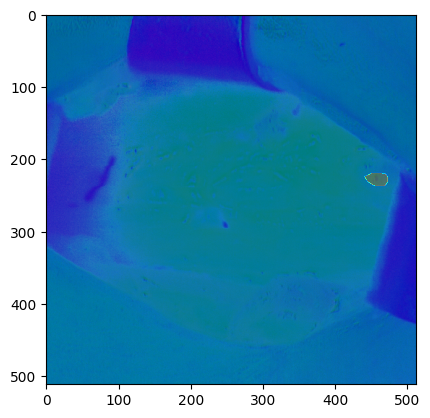

In [5]:
from matplotlib import pyplot as plt
plt.imshow(raw_gt, cmap='jet')
plt.imshow(raw_rgb, alpha=0.5)

In [6]:
npy = NpyHSDataset(config, transform=None)

Loaded 163 pairs of .npy files
Concatenated data shape: (83456, 512, 64), labels shape: (83456, 512)
Applied PCA: reduced from 64 to 15 components
Created 3832779 patches of size 15x15
